<center><h1> TD N°2 : SVM non linéaire</h1></center>

## Import package

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.svm import SVC
import seaborn as sns

In [2]:
#Modélisation 
#Classifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC 
from sklearn.linear_model import SGDClassifier , LogisticRegression

from sklearn.metrics import confusion_matrix , accuracy_score, recall_score

from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV
from sklearn_evaluation import plot

In [3]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats.mstats import winsorize

In [4]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter


## Function

In [5]:
def svm_f_importances(coef_svm , names):
    ''' 
    Cette fonction permet de visualiser l'importance de chaque variable pour le modèle SVM
    Vous devez passer 2 arguments :
    
    - coef_svm : Les coéfficients du modèle disponible après votre .fit()
      On le récupère avec la commande suite  svc_fit.coef_[0]
      
    - names : est le nom des features que vous avez utilisée.
      ATTENTION à passer dans le même ordre que pour l'entrainement du modèle
    
    '''
    imp = coef_svm
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

#features_names = ['input1', 'input2']
#svm = svm.SVC(kernel='linear')
#svm.fit(X, Y)
#f_importances(svm.coef_[0], features_names)

In [6]:
def plot_predictions(clf, axes):
    
    ''''
    Plot prediction permet de visualiser la frontière de décision d'un SVM avec kernel.
    Elle ne marche qu'avec 2 features (2 dimensions)
    
    IL FAUT également tracer votre X_train avant de faire cette fonction!!
    
    '''
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    

#clf = model SVC
#axes = [xlim_min, xlim_max, ylim_min, ylim_max]

In [7]:
def winsorize_data(xtrain, xtest, feature):

    """_summary_

    Fonction permettant de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.

    Pour se prémunir d'un data leak.
    
    """
    
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return(xtrain_winsorized, xtest_winsorized)

## Enoncé TD

#### Exploration and data analysis (EDA)

1) Importer le jeu de données breast cancer disponible dans le module sklearn.datasets<br>
2) Analyser le dataset avec des statistiques descriptives<br>
3) Recoder les variables si nécessaire<br>
4) Faites une première étape de feature selection avec votre analyse statistique<br> 

#### Modélisation binaire

5) Importer les modèles suivants **SGDClassifier, SVC, LogisticRegression**<br>
6) Regarder l'effet du changement de noyau pour la fonction **SVC**<br>
- 6.1) Garder uniquement 2 features pour cette partie<br>
- 6.2) Utiliser la fonction **plot_predictions** pour voir la fonction de décision en fonction du noyau<br>
- 6.3) Varier les autres hyperparamètres en plus du **kernel**<br>

7) Lancer vos modèles sur les features que vous avez gardés avec vos statistiques descriptives( pour **SVC** utiliser plusieurs noyaux)<br>
8) Réaliser une cross-validation afin de déterminer des modèles prometteurs. Ne pas tuner les hyperparamètres<br>
9) Analyser vos résultats (metrics, erreurs de prédictions, ...)<br>
10) Tuner pour obtenir le meilleur modèle et réaliser une prédiction<br>
- 10.1) Analyser les variables importantes de votre modèle



## Description du dataset



<img src="https://www.researchgate.net/profile/Faiza-Khattak/publication/281099329/figure/fig3/AS:284623327252504@1444870897714/Example-images-of-the-breast-cancer-dataset-From-left-to-right-First-three-are.png" alt="image_breast_cancer.png" style="width:800px;"/>
</p>

Le data set breast cancer contient des informations sur la caractéristiques de tumeur bénine ou non.<br>
Les informations sont issues d'images  (exmple ci-dessus) et un docteur à labélisé si la tumeur était bénine ou maligne.

##### Info du dataset

Attribute Information:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)
        
Chaque attribut possède 3 informations. La moyenne(mean), l'écart type(standart error) et le maximun("worst")


## Code

## Exploration and data analysis


#### 1) Importer le jeu de données breast cancer disponible dans le module sklearn.datasets

In [8]:
#Load dataset breast cancer
data = load_breast_cancer()

In [9]:
breast = pd.DataFrame(data = np.c_[data.data,data.target], columns=list(data.feature_names)+['target'] )
#Nom des colonnes et remplacer les espaces par un "_"
features_name = [name.replace(" ", "_") for name in data.feature_names]
breast.columns= features_name+['target']

In [10]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [11]:
# On inverse la modalité de référence
#breast.target = 1- breast.target

# 0 is Benin
# 1 is Maligne

##### 2) Analyser le dataset avec des statistiques descriptives

- Statistiques univariées
- Statistiques bivariées
- Statistiques multivariées (si vous avez le temps)

In [12]:
breast.describe()

mean_radius  mean_texture  mean_perimeter    mean_area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean_smoothness  mean_compactness  mean_concavity  mean_concave_points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean_symmetry  mean_fractal_dimension  ...  worst_texture  \
count     569.000000              569.000000  ...     569.000000   
mean        0.181162                0.062798  ...      25.677223   
std         0.027414                0.007060  ...       6.146258   
min         0.106000                0.049960  ...      12.020000   
25%         0.161900                0.057700  ...      21.080000   
50%         0.179200                0.061540  ...      25.410000   
75%         0.195700                0.066120  ...      29.720000   
max         0.304000                0.097440  ...      49.540000   

       worst_perimeter   worst_area  worst_smoothness  worst_compactness  \
count       569.000000   569.000000        569.000000         569.000000   
mean        107.261213   880.583128          0.132369           0.254265   
std          33.602542   569.356993          0.022832           0.157336   
min          50.410000   185.200000          0.071170           0.027290   
25%          84.110000   515.300000          0.116600           0.147200   
50%          97.660000   686.500000          0.131300           0.211900   
75%         125.400000  1084.000000          0.146000           0.339100   
max         251.200000  4254.000000          0.222600           1.058000   

       worst_concavity  worst_concave_points  worst_symmetry  \
count       569.000000            569.000000      569.000000   
mean          0.272188              0.114606        0.290076   
std           0.208624              0.065732        0.061867   
min           0.000000              0.000000        0.156500   
25%           0.114500              0.064930        0.250400   
50%           0.226700              0.099930        0.282200   
75%           0.382900              0.161400        0.317900   
max           1.252000              0.291000        0.663800   

       worst_fractal_dimension      target  
count               569.000000  569.000000  
mean                  0.083946    0.627417  
std                   0.018061    0.483918  
min                   0.055040    0.000000  
25%                   0.071460    0.000000  
50%                   0.080040    1.000000  
75%                   0.092080    1.000000  
max                   0.207500    1.000000  

[8 rows x 31 columns]

<Axes: >

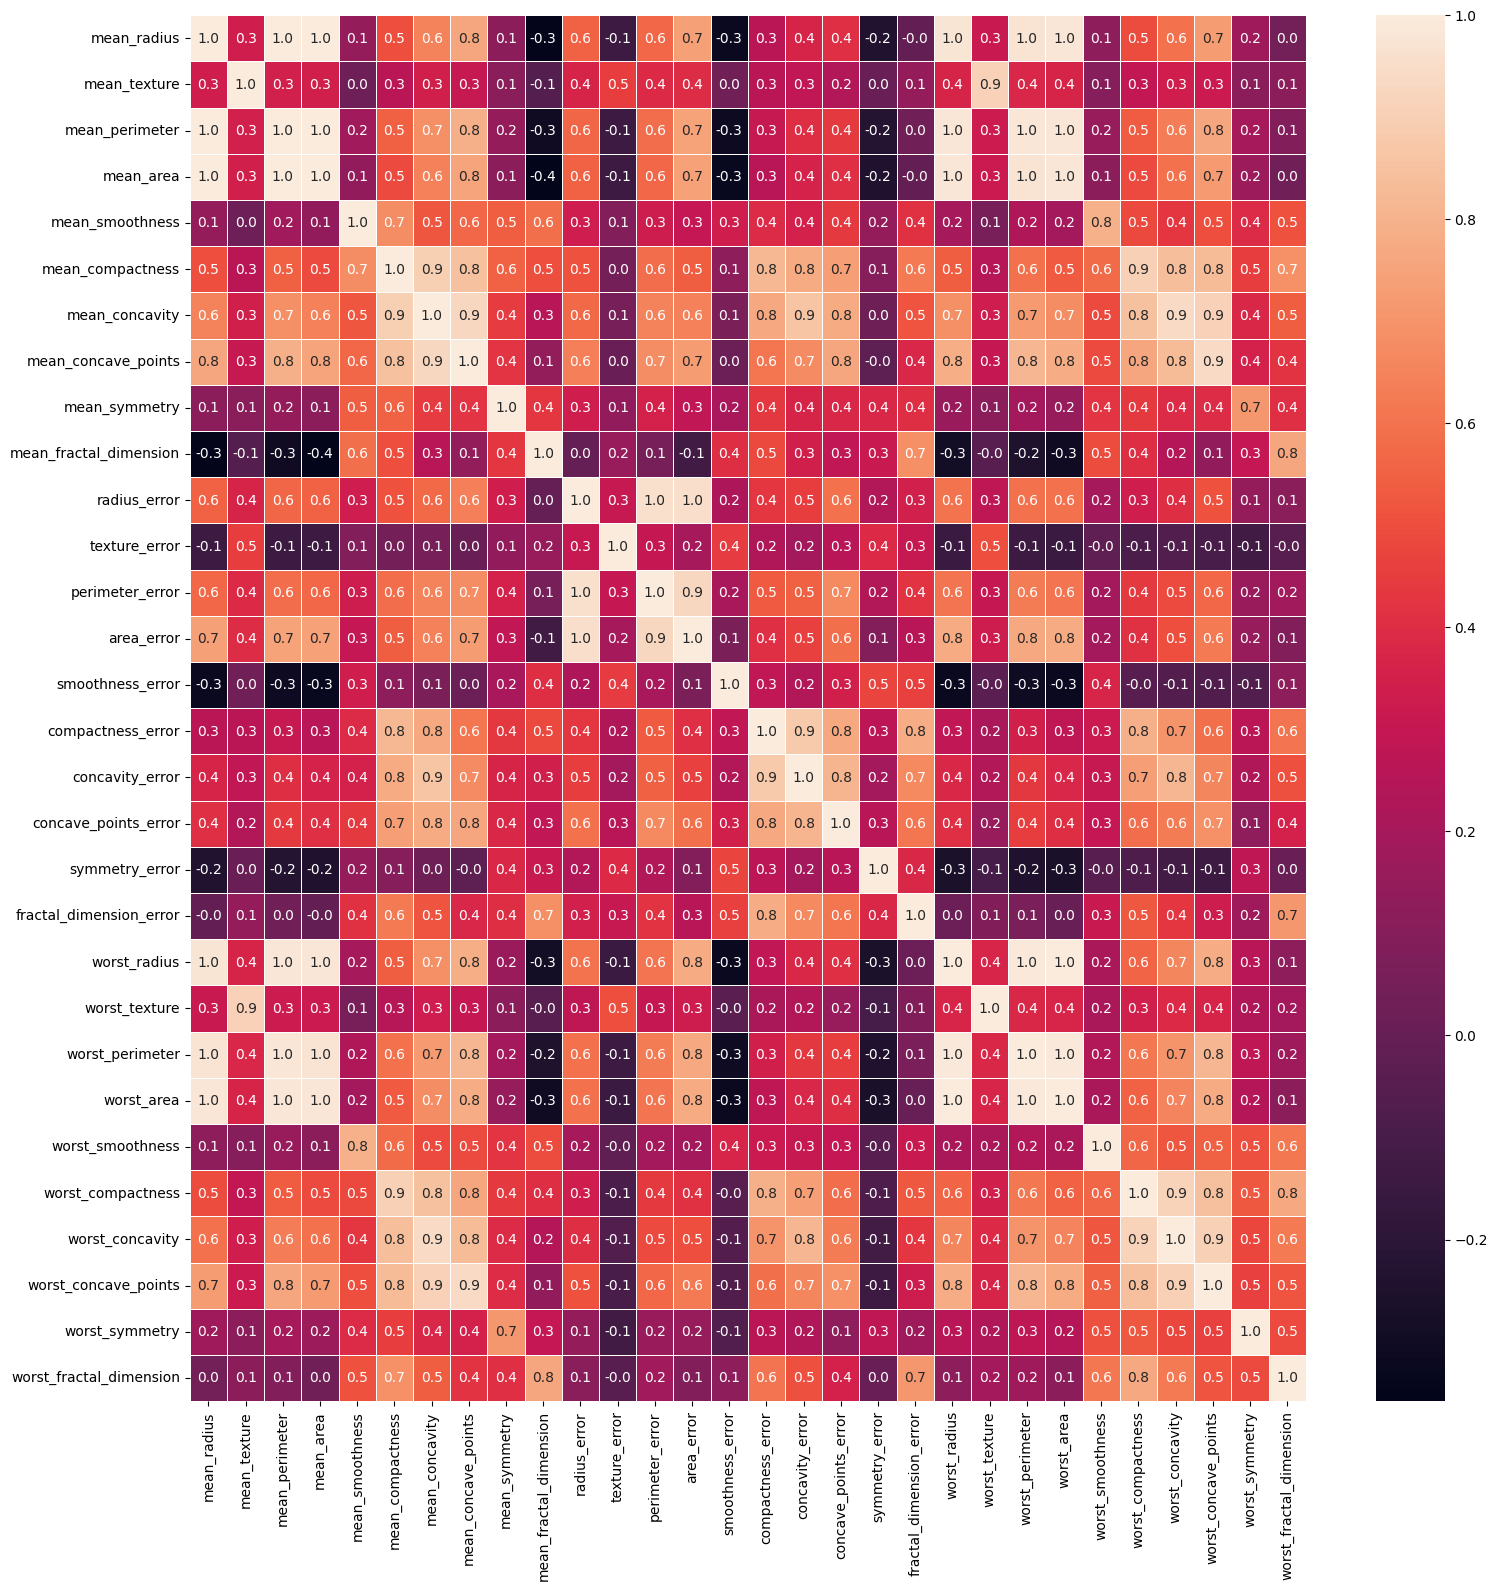

In [13]:
#correlation map avec spearman pour travailler sur le rang et non les valeurs
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(breast[features_name].corr(method="spearman"), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [14]:
m_corr = breast[features_name].corr(method="spearman")
fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(m_corr[abs(m_corr)>=0.80],annot = True, fmt = '.2f')

<Axes: >

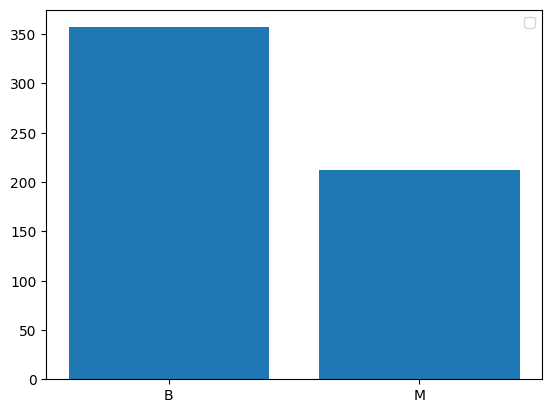

In [15]:
#Attention données légérement déséquilibrée
plt.bar(x=['B','M'], height=breast.target.value_counts())
plt.legend()

In [16]:
breast.target.value_counts()

target
1.0    357
0.0    212
Name: count, dtype: int64

#### 3) Recoder les variables si nécessaire


In [17]:
breast['target'] = breast.target.astype('int32')

In [18]:
# On affiche par lot de 10 feature
data_dia = breast.target
data = breast[features_name]
data_n_2 = (data - data.mean()) / (data.std())              # standardization

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'mean_radius'),
  Text(1, 0, 'mean_texture'),
  Text(2, 0, 'mean_perimeter'),
  Text(3, 0, 'mean_area'),
  Text(4, 0, 'mean_smoothness'),
  Text(5, 0, 'mean_compactness'),
  Text(6, 0, 'mean_concavity'),
  Text(7, 0, 'mean_concave_points'),
  Text(8, 0, 'mean_symmetry'),
  Text(9, 0, 'mean_fractal_dimension')])

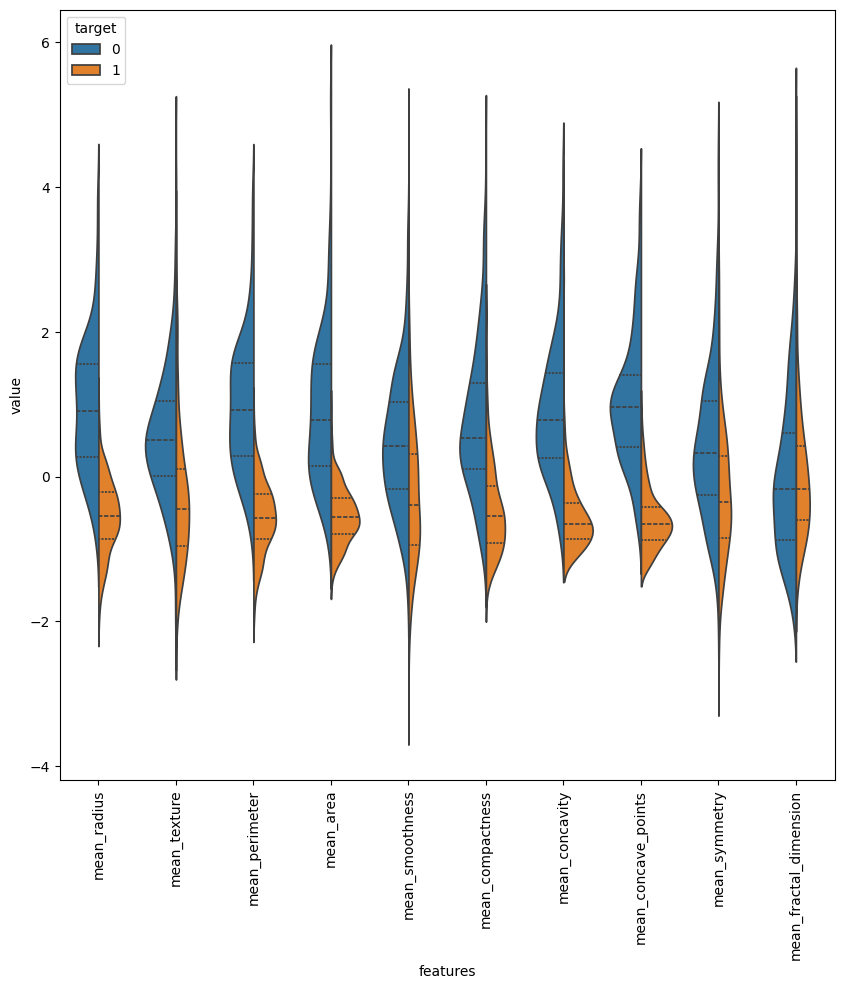

In [19]:
# On affiche pas lot de 10 feature
data_dia = breast.target
data = breast[features_name]
data_n_2 = (data - data.mean()) / (data.std())              # standardization
#Melt permet de faire un pivot sur nos données
data = pd.concat([breast.target,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="target",
                    var_name="features",
                    value_name='value')

#Plt figure
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=data,split=True, inner="quart")
plt.xticks(rotation=90)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'radius_error'),
  Text(1, 0, 'texture_error'),
  Text(2, 0, 'perimeter_error'),
  Text(3, 0, 'area_error'),
  Text(4, 0, 'smoothness_error'),
  Text(5, 0, 'compactness_error'),
  Text(6, 0, 'concavity_error'),
  Text(7, 0, 'concave_points_error'),
  Text(8, 0, 'symmetry_error'),
  Text(9, 0, 'fractal_dimension_error')])

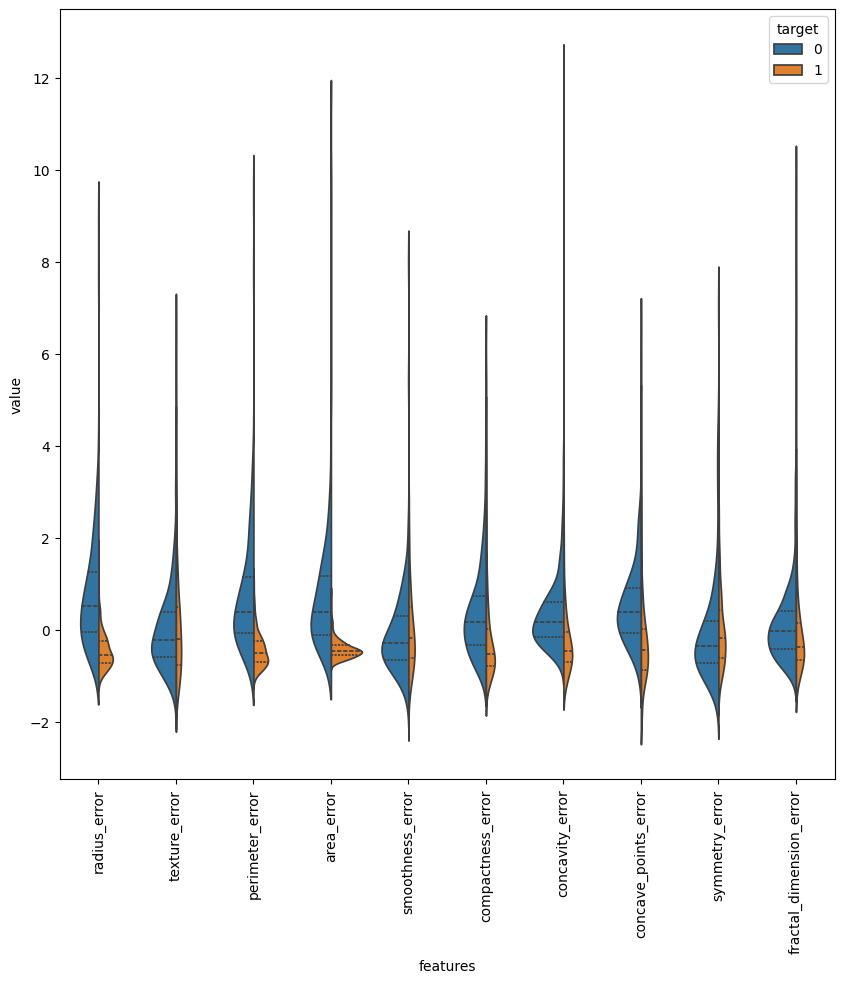

In [20]:
# On affiche pas lot de 10 feature
data_dia = breast.target
data = breast[features_name]
data_n_2 = (data - data.mean()) / (data.std())              # standardization
#Melt permet de faire un pivot sur nos données
data = pd.concat([breast.target,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="target",
                    var_name="features",
                    value_name='value')

#Plt figure
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=data,split=True, inner="quart")
plt.xticks(rotation=90)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'worst_radius'),
  Text(1, 0, 'worst_texture'),
  Text(2, 0, 'worst_perimeter'),
  Text(3, 0, 'worst_area'),
  Text(4, 0, 'worst_smoothness'),
  Text(5, 0, 'worst_compactness'),
  Text(6, 0, 'worst_concavity'),
  Text(7, 0, 'worst_concave_points'),
  Text(8, 0, 'worst_symmetry'),
  Text(9, 0, 'worst_fractal_dimension')])

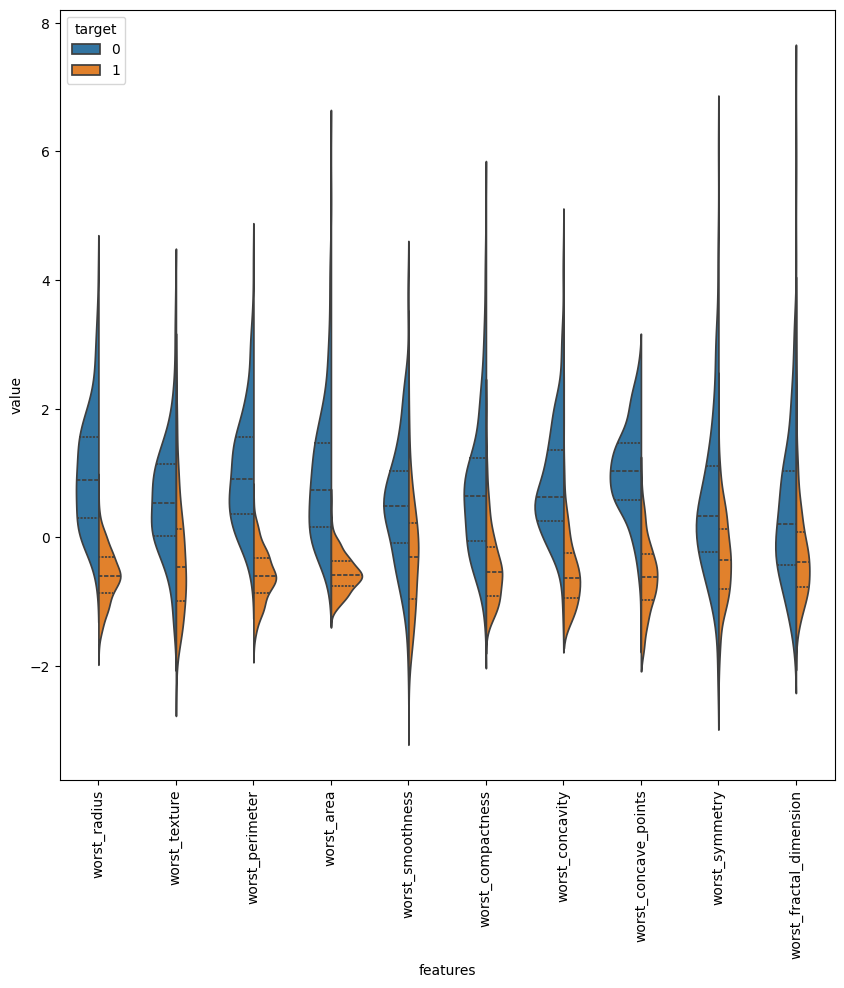

In [21]:
# On affiche pas lot de 10 feature
data_dia = breast.target
data = breast[features_name]
data_n_2 = (data - data.mean()) / (data.std())              # standardization
#Melt permet de faire un pivot sur nos données
data = pd.concat([breast.target,data_n_2.iloc[:,20:31]],axis=1)
data = pd.melt(data,id_vars="target",
                    var_name="features",
                    value_name='value')

#Plt figure
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=data,split=True, inner="quart")
plt.xticks(rotation=90)


In [22]:
#Nb de NA par feature

breast[features_name].isna().sum(axis=0)

#Iris.isna() retourne un true/false
#sum(axis=0) va faire la sum par colonne et true=1 false=0

mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave_points        0
mean_symmetry              0
mean_fractal_dimension     0
radius_error               0
texture_error              0
perimeter_error            0
area_error                 0
smoothness_error           0
compactness_error          0
concavity_error            0
concave_points_error       0
symmetry_error             0
fractal_dimension_error    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave_points       0
worst_symmetry             0
worst_fractal_dimension    0
dtype: int64

#### 4) Faites une première étape de feature selection avec votre analyse des statistiques

In [23]:
#Il existe plusieurs méthodes pour réaliser une feature selection.

#De la plus simple qui s'appuie sur l'analyse statistique comme étude des corrélations
#Mais nous pouvons également utiliser des modèles pour rechercher les variables importantes pour notre modèle (random forest, modèle avec régularisation)
#Pour le TD nous choissons l'étude des corrélations

In [24]:
#On ne garde que la partie supérieur de la matrice de corrélation car symétrique
#On inclut pas la diagonale car variable corrlée à 100% avec elle même
upper_tri = m_corr.where(np.triu(np.ones(m_corr.shape),k=1).astype(np.bool))
print(upper_tri)

                         mean_radius  mean_texture  mean_perimeter  mean_area  \
mean_radius                      NaN      0.340956        0.997802   0.999602   
mean_texture                     NaN           NaN        0.348142   0.344145   
mean_perimeter                   NaN           NaN             NaN   0.997068   
mean_area                        NaN           NaN             NaN        NaN   
mean_smoothness                  NaN           NaN             NaN        NaN   
mean_compactness                 NaN           NaN             NaN        NaN   
mean_concavity                   NaN           NaN             NaN        NaN   
mean_concave_points              NaN           NaN             NaN        NaN   
mean_symmetry                    NaN           NaN             NaN        NaN   
mean_fractal_dimension           NaN           NaN             NaN        NaN   
radius_error                     NaN           NaN             NaN        NaN   
texture_error               

In [25]:
#Suppresion des colonnes avec corrélation supérieur à 0.85
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(to_drop)

['mean_perimeter', 'mean_area', 'mean_concavity', 'mean_concave_points', 'perimeter_error', 'area_error', 'concavity_error', 'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area', 'worst_compactness', 'worst_concavity', 'worst_concave_points']


## Attention

Ce type de méthode pour éliminer les features corrélés permet d'avancer très vite mais n'est pas optimale.<br>
On supprimer les 2 variables corrélées mais parfois une des 2 pourrait être conservée car non corrélée avec les autres features

In [26]:
#Drop des colonnes
breast_no_corr = breast.drop(to_drop, axis=1)

In [27]:
features_name_corr = breast_no_corr.columns

## Modélisation Binaire

#### 5) Importer les modèles suivants SGDClassifier, SVC, LogisticRegression

In [28]:
#Regression logistique
lgr = LogisticRegression( random_state=42)
#lgr.fit(X_train_sc, y_train)

#Linear SVM
l_SVC = LinearSVC(random_state=42, max_iter=2000)
#l_SVC.fit(X_train_sc, y_train)

#SVM avec kernel
svc = SVC(kernel='linear',random_state=42)


#SGD classifier
sgdc_svm = SGDClassifier(loss='hinge' ,random_state=42)


#### 6) Regarder l'effet du changement de noyau pour la fonction SVC

6.1) Garder uniquement **2 features** pour cette partie<br>
6.2) Utiliser la fonction **plot_predictions** pour voir la fonction de décision en fonction du noyau<br>
6.3) Varier les autres hyperparamètres en plus du kernel<br>

In [29]:
#Col names
list_two_col = breast_no_corr.iloc[:,0:2].columns

### Kernel : Poly

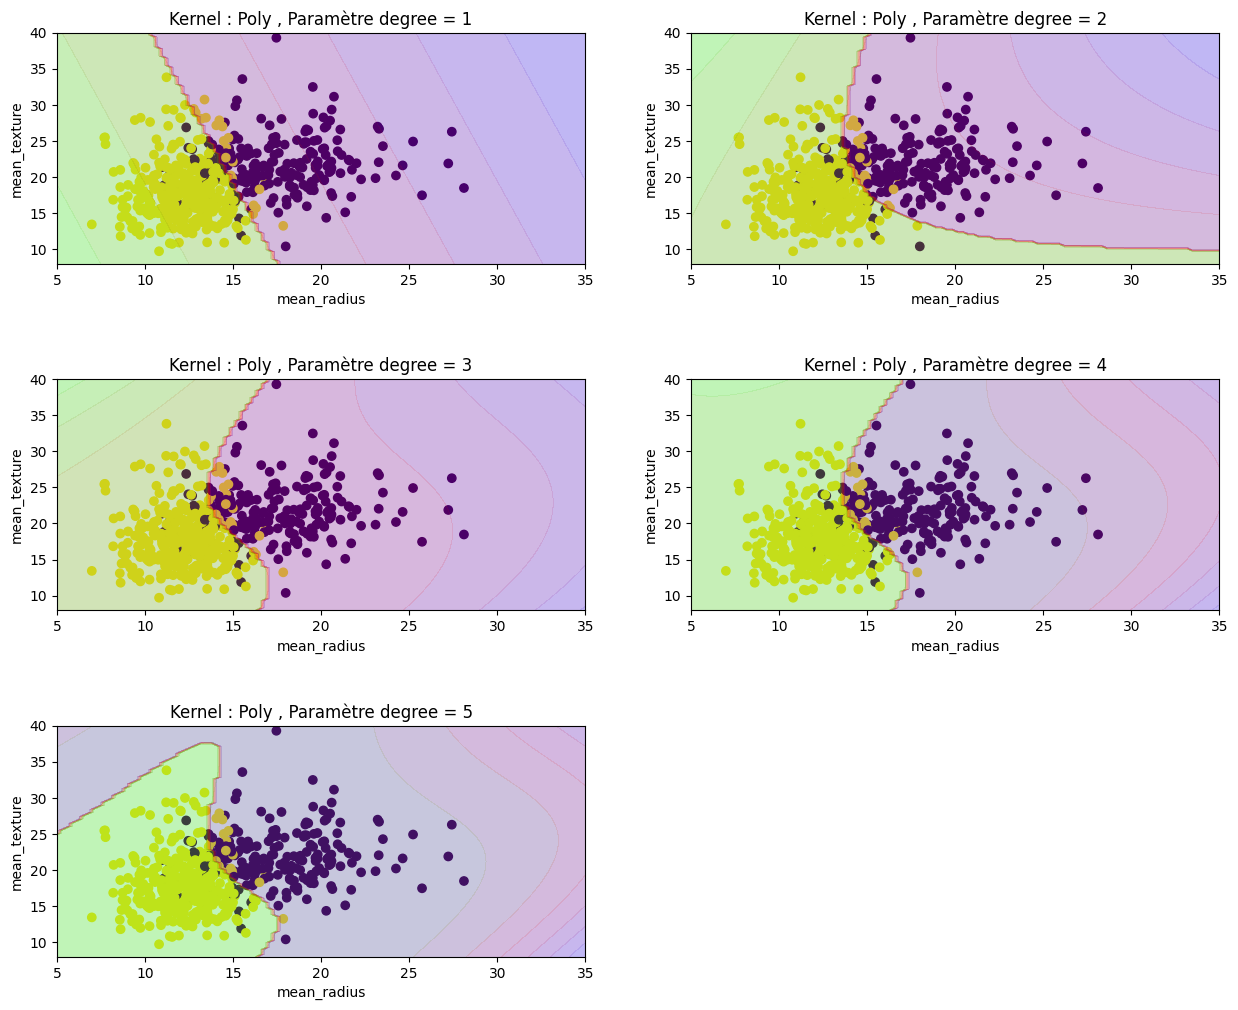

In [30]:
#Degree poly
d = [1,2,3,4,5]
#Taille image et subplot 
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i,j  in enumerate(d):

    #Train
    class_svc = SVC( random_state=42 , kernel='poly', degree=int(j))
    class_svc.fit(breast_no_corr.iloc[:,0:2], breast_no_corr['target'])
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, i + 1)
    #Plot
    plt.scatter(breast_no_corr.iloc[:,0], breast_no_corr.iloc[:,1], c=breast_no_corr.target)
    plot_predictions(class_svc, [5, 35, 8, 40])
    plt.title('Kernel : Poly , Paramètre degree = '+str(j))
    plt.xlabel(list_two_col[0])
    plt.ylabel(list_two_col[1])

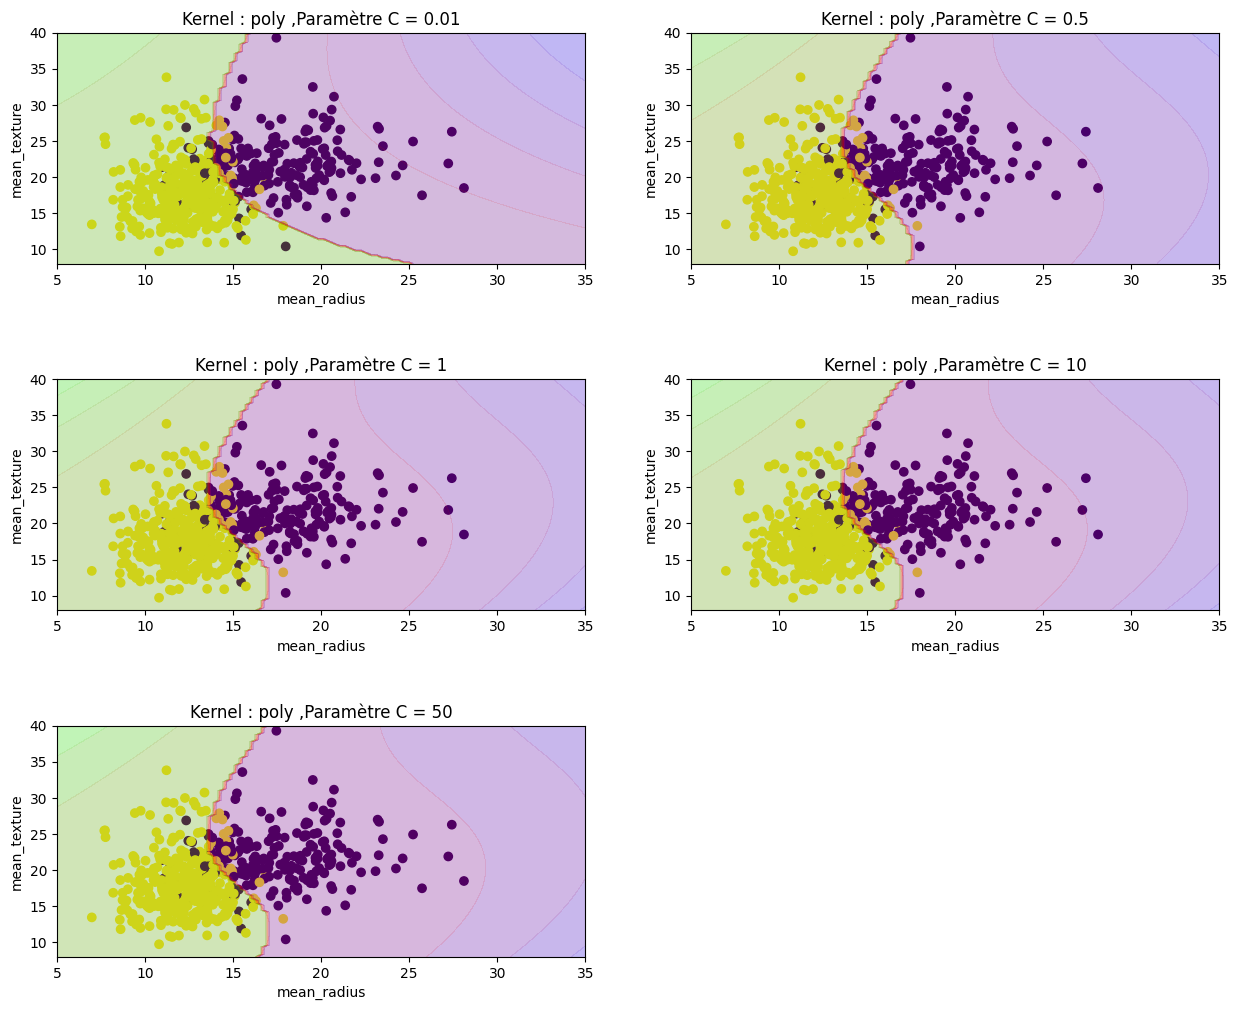

In [31]:
#Degree poly
C = [0.01, 0.5, 1, 10, 50]
#Taille image et subplot 
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i,j  in enumerate(C):

    #Train
    class_svc = SVC(C=j ,random_state=42 , kernel='poly', degree=3)
    class_svc.fit(breast_no_corr.iloc[:,0:2], breast_no_corr['target'])
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, i + 1)
    #Plot
    plt.scatter(breast_no_corr.iloc[:,0], breast_no_corr.iloc[:,1], c=breast_no_corr.target)
    plot_predictions(class_svc, [5, 35, 8, 40])
    plt.title('Kernel : poly ,Paramètre C = '+str(j))
    plt.xlabel(list_two_col[0])
    plt.ylabel(list_two_col[1])

### Kernel : RBF

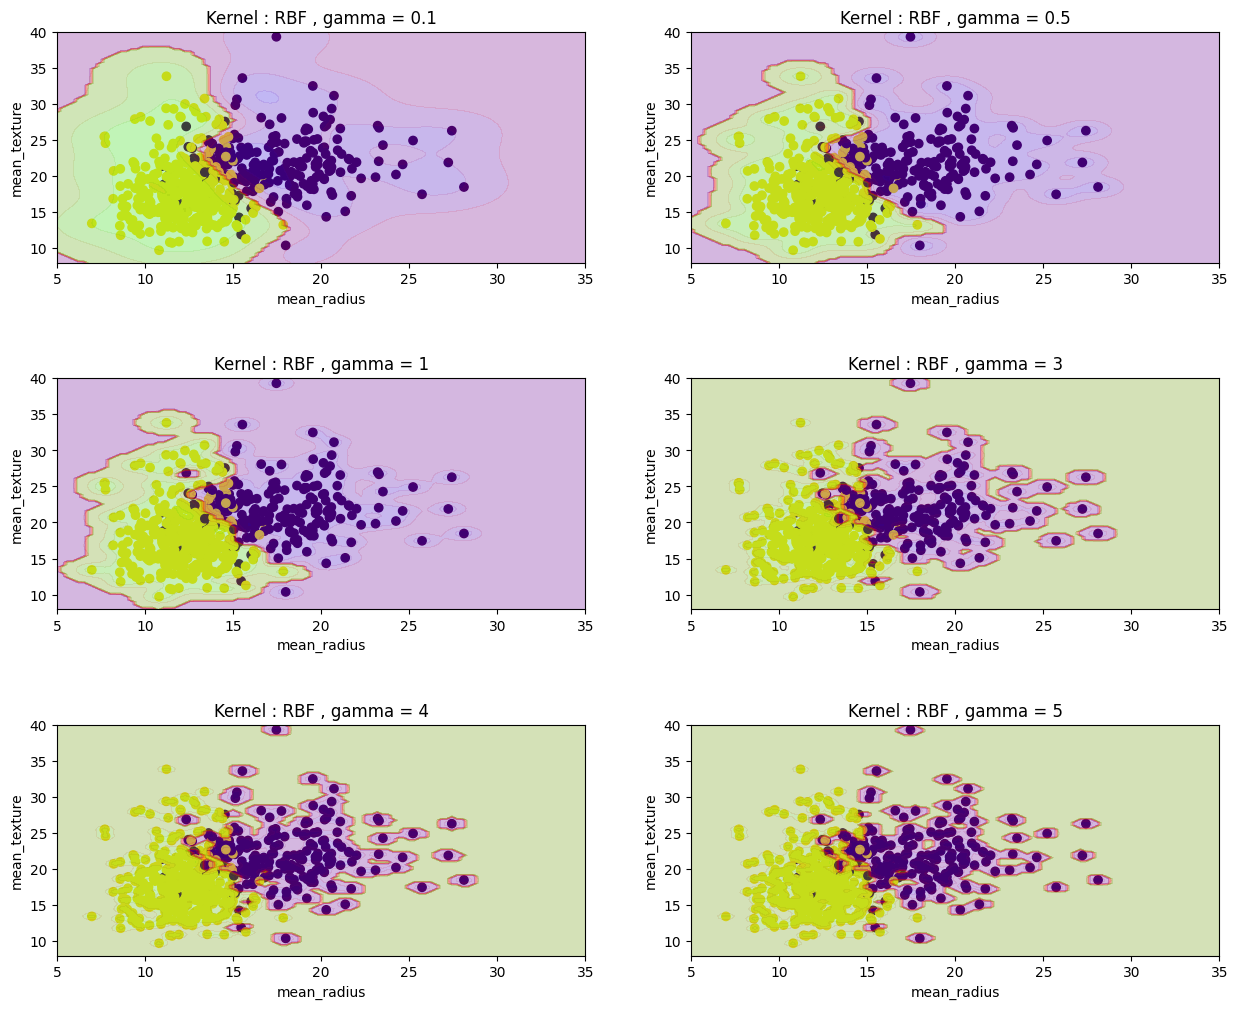

In [32]:
#Degree poly
gamma = [0.1,0.5,1,3,4,5]
#Taille image et subplot 
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i,j  in enumerate(gamma):
    #Train
    class_svc = SVC( random_state=42 , kernel='rbf', gamma=j)
    class_svc.fit(breast_no_corr.iloc[:,0:2], breast_no_corr['target'])
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, i + 1)
    #Plot
    plt.scatter(breast_no_corr.iloc[:,0], breast_no_corr.iloc[:,1], c=breast_no_corr.target)
    plot_predictions(class_svc, [5, 35, 8, 40])
    plt.title('Kernel : RBF , gamma = '+str(j))
    plt.xlabel(list_two_col[0])
    plt.ylabel(list_two_col[1])

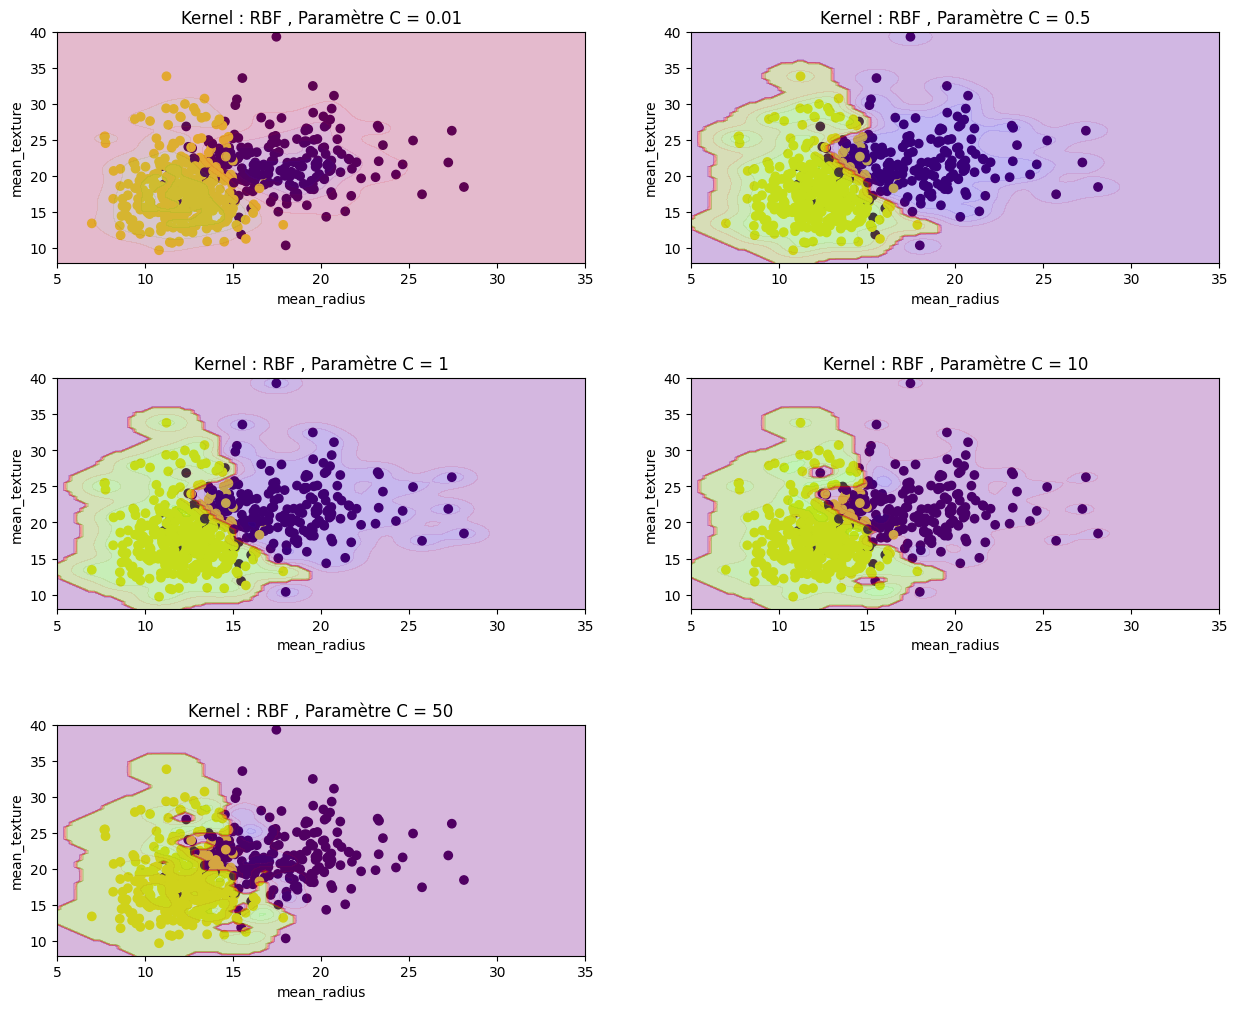

In [33]:
#Degree poly
C = [0.01, 0.5, 1, 10, 50]
#Taille image et subplot 
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i,j  in enumerate(C):

    #Train
    class_svc = SVC(C=j ,random_state=42 , kernel='rbf', gamma=0.5)
    class_svc.fit(breast_no_corr.iloc[:,0:2], breast_no_corr['target'])
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, i + 1)
    #Plot
    plt.scatter(breast_no_corr.iloc[:,0], breast_no_corr.iloc[:,1], c=breast_no_corr.target)
    plot_predictions(class_svc, [5, 35, 8, 40])
    plt.title('Kernel : RBF , Paramètre C = '+str(j))
    plt.xlabel(list_two_col[0])
    plt.ylabel(list_two_col[1])

#### 7) Lancer vos modèles sur les features que vous avez gardés avec vos statistiques descriptives( pour **SVC** utiliser plusieurs noyaux)

On utilise un dataset avec autant features que vous souhaitez maintenant

Avant de vouloir modéliser il faut régler 2 problèmes :

- Le problème de imbalanced target

- Standardiser nos colonnes




## Remarque sur le *data leakage* méthodologique (et non informationnel)

L’utilisation de techniques de **sous-échantillonnage (undersampling)** ou de **sur-échantillonnage (oversampling)** sur le jeu d’entraînement est une bonne pratique pour améliorer les performances d’un modèle, notamment en présence de classes déséquilibrées.  
Ces méthodes permettent au modèle de mieux apprendre les motifs (patterns) associés à la classe minoritaire (ou majoritaire).

En revanche, **ces techniques ne doivent jamais être appliquées au jeu de test**.  
Le jeu de test doit refléter **la distribution réelle du phénomène étudié**, telle qu’elle existe dans le monde réel, sans aucune altération.

Modifier la distribution du jeu de test introduit un **data leakage méthodologique** :  
on facilite artificiellement les prédictions du modèle en le testant sur des données dont la structure a été modifiée, ce qui conduit à une évaluation biaisée et trop optimiste des performances.


In [ ]:
# On split en premier

X = breast_no_corr.iloc[:,:-1]
y = breast_no_corr['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
#On applique sa strtégie de resampling post split
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(X_resampled.shape)

(338, 16)


In [36]:
#Winsorize outliers
for col in X_train.columns:
    print(f" winsorization de la variable : {col}") 
    X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

 winsorization de la variable : mean_radius
 winsorization de la variable : mean_texture
 winsorization de la variable : mean_smoothness
 winsorization de la variable : mean_compactness
 winsorization de la variable : mean_symmetry
 winsorization de la variable : mean_fractal_dimension
 winsorization de la variable : radius_error
 winsorization de la variable : texture_error
 winsorization de la variable : smoothness_error
 winsorization de la variable : compactness_error
 winsorization de la variable : concave_points_error
 winsorization de la variable : symmetry_error
 winsorization de la variable : fractal_dimension_error
 winsorization de la variable : worst_smoothness
 winsorization de la variable : worst_symmetry
 winsorization de la variable : worst_fractal_dimension


In [37]:
#Scaling features

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
# Test d'un modèle RBF

class_svc = SVC(C=0.1, random_state=42 , kernel='rbf', gamma=0.2)
class_svc.fit(X_train_sc, y_train)
print('Accuray train : ' + str(accuracy_score(y_train, class_svc.predict(X_train_sc))))
print('----------------------')
print('Accuray test : ' + str(accuracy_score(y_test, class_svc.predict(X_test_sc))))
print('-----------------------------------')
print('recall score train : ' + str(recall_score(y_train, class_svc.predict(X_train_sc), pos_label=0)))
print('-----------------------------------')
print('recall score test : ' + str(recall_score(y_test, class_svc.predict(X_test_sc), pos_label=0)))

Accuray train : 0.8175824175824176
----------------------
Accuray test : 0.7631578947368421
-----------------------------------
recall score train : 0.5088757396449705
-----------------------------------
recall score test : 0.37209302325581395


In [ ]:
# Tester modèle poly

class_svc = SVC(C=1, random_state=42 , kernel='poly', degree=1)
class_svc.fit(X_train_sc, y_train)
print('Accuray train : ' + str(accuracy_score(y_train, class_svc.predict(X_train_sc))))
print('----------------------')
print('Accuray test : ' + str(accuracy_score(y_test, class_svc.predict(X_test_sc))))
print('-----------------------------------')
print('recall score train : ' + str(recall_score(y_train, class_svc.predict(X_train_sc), pos_label=0)))
print('-----------------------------------')
print('recall score test : ' + str(recall_score(y_test, class_svc.predict(X_test_sc), pos_label=0)))

Accuray train : 0.967032967032967
----------------------
Accuray test : 0.9473684210526315
-----------------------------------
recall score train : 0.9289940828402367
-----------------------------------
recall score test : 0.9302325581395349


#### 8) Réaliser une cross-validation afin de déterminer des modèles prometteurs. Ne pas tuner les hyperparamètres 

In [40]:
# Get cross_val_score for each function

svc_poly = SVC(random_state=42 , kernel='poly')
cvs_svc_poly = cross_val_score(svc_poly, X_train_sc, y_train, cv=5, scoring='accuracy')

svc_rbf = SVC( random_state=42 , kernel='rbf' )
cvs_svc_rbf = cross_val_score(svc_rbf, X_train_sc, y_train, cv=5, scoring='accuracy')

svc_linear = SVC( random_state=42 , kernel='linear')
cvs_svc_linear = cross_val_score(svc_linear, X_train_sc, y_train, cv=5, scoring='accuracy')

In [41]:
#Get data output from cross_val_score
df_cross = pd.DataFrame(np.transpose(np.c_[cvs_svc_poly, cvs_svc_rbf, cvs_svc_linear]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross['model'] = ['poly','rbf','linear']

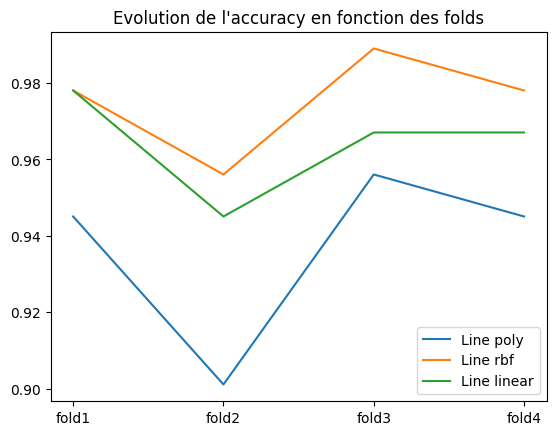

In [42]:
#Regardons l'évolution des scores pour chaque fold
for row in range(df_cross.shape[0]):
    plt.plot( df_cross.iloc[row,0:4] ,label='Line '+str(df_cross.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

#### 9) Analyser vos résultats (metrics, erreurs de prédictions, ...)

In [43]:
for i in range(3):

    mean_model = df_cross.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a une accuracy de '  + str(mean_model) + ' et un std : ' + str(std_model))
    print('-----------------------------------')
    


Le modèle N° 0 a une accuracy de 0.9208791208791208 et un std : 0.041409766332784134
-----------------------------------
Le modèle N° 1 a une accuracy de 0.9736263736263737 et un std : 0.012529400275814694
-----------------------------------
Le modèle N° 2 a une accuracy de 0.9604395604395604 et un std : 0.014743305346152466
-----------------------------------


A ce stade vous pouvez:

- Regarder la matrice de confusion pour rentrer en détail de vos prédictions.

- Regarder les observations mal prédites et voir si elles possèdent une distribution différentes de nos données

- Changer votre feature engineering

#### 10) Tuner pour obtenir le meilleur modèle et réaliser une prédiction


In [44]:
#Tuning three kernels
params = [
    {"kernel": ["rbf"], "gamma": [0.01, 0.1,0.5,1,2], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "degree":[1,2,3,4],"C": [1, 10, 100, 1000]},
    {"kernel": ["linear"],"C": [1, 10, 100, 1000]}
]

c_svc = SVC(random_state=42)

grid_c_svc = GridSearchCV(c_svc, param_grid=params, cv=5, return_train_score=True)

In [45]:
take_grid = grid_c_svc.fit(X_train_sc, y_train)

In [46]:
#On garde le meilleur modèle et on refait un grid search uniquement sur ce modèle
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))

La meilleur combinaison d'estimateur est: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
pour un score de: 0.9714285714285713


In [47]:
#Examiner tous les fold par ordre
results_df = pd.DataFrame(take_grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(results_df["params"]\
                                  .apply(lambda x: "_".join(str(val) for val in x.values()))
                                 ).rename_axis("kernel")

results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

params  rank_test_score  \
kernel                                                                        
1_0.1_rbf          {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}                1   
10_0.01_rbf      {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}                2   
1_1_poly           {'C': 1, 'degree': 1, 'kernel': 'poly'}                3   
10_0.1_rbf        {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}                4   
1_linear                      {'C': 1, 'kernel': 'linear'}                5   
10_1_poly         {'C': 10, 'degree': 1, 'kernel': 'poly'}                6   
1_0.01_rbf        {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                6   
100_1_poly       {'C': 100, 'degree': 1, 'kernel': 'poly'}                6   
1000_0.1_rbf    {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}                9   
100_0.1_rbf      {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}                9   
10_linear                    {'C': 10, 'kernel': 'linear'}                9   
100_0.01_rbf    {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}                9   
100_linear                  {'C': 100, 'kernel': 'linear'}               13   
1000_1_poly     {'C': 1000, 'degree': 1, 'kernel': 'poly'}               13   
1000_linear                {'C': 1000, 'kernel': 'linear'}               15   
10_3_poly         {'C': 10, 'degree': 3, 'kernel': 'poly'}               16   
1000_3_poly     {'C': 1000, 'degree': 3, 'kernel': 'poly'}               16   
100_3_poly       {'C': 100, 'degree': 3, 'kernel': 'poly'}               18   
1000_0.01_rbf  {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}               19   
1_3_poly           {'C': 1, 'degree': 3, 'kernel': 'poly'}               20   
1000_0.5_rbf    {'C': 1000, 'gamma': 0.5, 'kernel': 'rbf'}               21   
10_0.5_rbf        {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}               21   
100_0.5_rbf      {'C': 100, 'gamma': 0.5, 'kernel': 'rbf'}               21   
1_0.5_rbf          {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}               24   
1_2_poly           {'C': 1, 'degree': 2, 'kernel': 'poly'}               25   
10_2_poly         {'C': 10, 'degree': 2, 'kernel': 'poly'}               26   
10_4_poly         {'C': 10, 'degree': 4, 'kernel': 'poly'}               27   
1_4_poly           {'C': 1, 'degree': 4, 'kernel': 'poly'}               28   
100_4_poly       {'C': 100, 'degree': 4, 'kernel': 'poly'}               29   
100_2_poly       {'C': 100, 'degree': 2, 'kernel': 'poly'}               30   
1000_4_poly     {'C': 1000, 'degree': 4, 'kernel': 'poly'}               31   
1000_2_poly     {'C': 1000, 'degree': 2, 'kernel': 'poly'}               32   
100_1_rbf          {'C': 100, 'gamma': 1, 'kernel': 'rbf'}               33   
1000_1_rbf        {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}               33   
10_1_rbf            {'C': 10, 'gamma': 1, 'kernel': 'rbf'}               33   
1_1_rbf              {'C': 1, 'gamma': 1, 'kernel': 'rbf'}               36   
1000_2_rbf        {'C': 1000, 'gamma': 2, 'kernel': 'rbf'}               37   
1_2_rbf              {'C': 1, 'gamma': 2, 'kernel': 'rbf'}               37   
10_2_rbf            {'C': 10, 'gamma': 2, 'kernel': 'rbf'}               37   
100_2_rbf          {'C': 100, 'gamma': 2, 'kernel': 'rbf'}               37   

               mean_test_score  std_test_score  
kernel                                          
1_0.1_rbf             0.971429        0.008791  
10_0.01_rbf           0.969231        0.018906  
1_1_poly              0.964835        0.018906  
10_0.1_rbf            0.962637        0.011207  
1_linear              0.960440        0.013187  
10_1_poly             0.958242        0.016150  
1_0.01_rbf            0.958242        0.014579  
100_1_poly            0.958242        0.012815  
1000_0.1_rbf          0.956044        0.013900  
100_0.1_rbf           0.956044        0.013900  
10_linear             0.956044        0.015541  
100_0.01_rbf          0.956044        0.020850  
100_linear            0.949451        0.017855 

In [48]:
#Tuning two kernel
params = [
    {"kernel": ["rbf"], "gamma": [0.001,0.005,0.01], "C": [1, 10]},
    {"kernel": ["poly"], "degree":[1],"C": [1, 10]},
    {"kernel": ["linear"],"C": [1, 10]}
]

c_svc = SVC(random_state=42)

grid_c_svc = GridSearchCV(c_svc, param_grid=params, cv=5, return_train_score=True)
take_grid = grid_c_svc.fit(X_train_sc, y_train)

In [49]:
results_df = pd.DataFrame(take_grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(results_df["params"]\
                                  .apply(lambda x: "_".join(str(val) for val in x.values()))
                                 ).rename_axis("kernel")

results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

params  rank_test_score  \
kernel                                                                      
10_0.005_rbf  {'C': 10, 'gamma': 0.005, 'kernel': 'rbf'}                1   
10_0.01_rbf    {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}                2   
1_1_poly         {'C': 1, 'degree': 1, 'kernel': 'poly'}                3   
1_linear                    {'C': 1, 'kernel': 'linear'}                4   
1_0.01_rbf      {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                5   
10_1_poly       {'C': 10, 'degree': 1, 'kernel': 'poly'}                5   
10_0.001_rbf  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}                5   
10_linear                  {'C': 10, 'kernel': 'linear'}                8   
1_0.005_rbf    {'C': 1, 'gamma': 0.005, 'kernel': 'rbf'}                9   
1_0.001_rbf    {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}               10   

              mean_test_score  std_test_score  
kernel                                         
10_0.005_rbf         0.969231        0.016150  
10_0.01_rbf          0.969231        0.018906  
1_1_poly             0.964835        0.018906  
1_linear             0.960440        0.013187  
1_0.01_rbf           0.958242        0.014579  
10_1_poly            0.958242        0.016150  
10_0.001_rbf         0.958242        0.016150  
10_linear            0.956044        0.015541  
1_0.005_rbf          0.945055        0.020850  
1_0.001_rbf          0.916484        0.022628

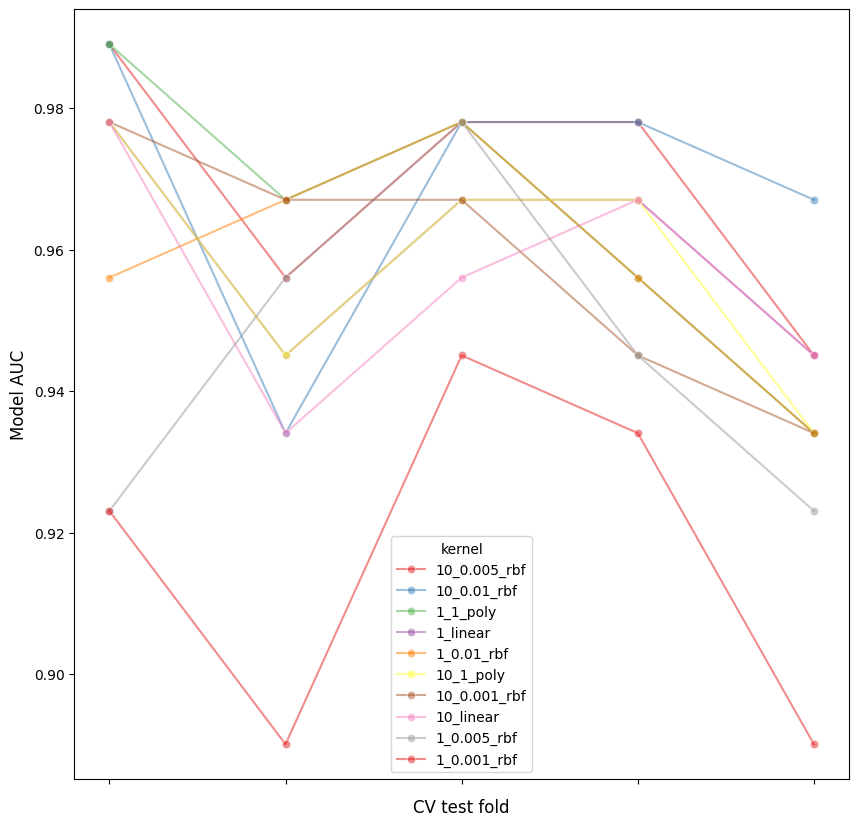

In [50]:
# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores

fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()



Notre meilleur modèle est aussi le plus simple :)! 
**Il s'agit du svm polynomial de degré 1 et C=1**

## on entraine notre dernier modèle

In [51]:
best_model = SVC(random_state=42, C=1, kernel='poly',degree=1)

In [52]:
best_model.fit(X_train_sc, y_train)

SVC(C=1, degree=1, kernel='poly', random_state=42)

<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 300x200 with 0 Axes>

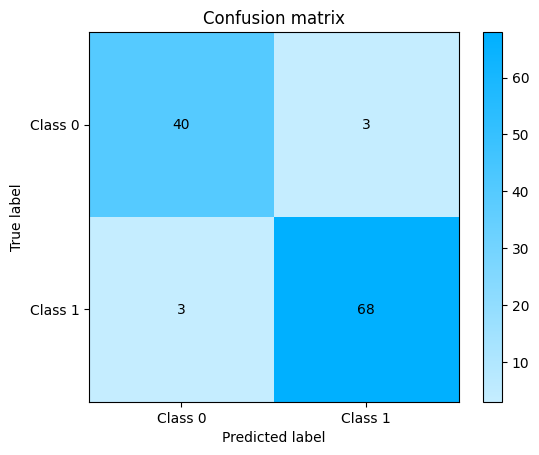

In [53]:
plt.figure(figsize=(3,2))
plot.confusion_matrix(best_model.predict(X_test_sc), y_test)

In [54]:
print('Training score: ' + str(best_model.score(X_train_sc,y_train)), 
      '\n',
      'Test score: ' + str(best_model.score(X_test_sc, y_test))
     )
 
    

Training score: 0.967032967032967 
 Test score: 0.9473684210526315


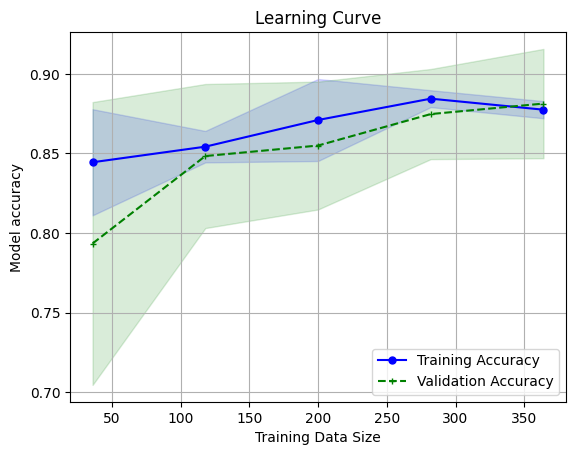

In [55]:
train_sizes, train_scores, test_scores = learning_curve(estimator=best_model, 
                                                        X=X_train, 
                                                        y=y_train,
                                                        cv=5, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Il ne semble pas avoir un d'overfitting au regard des learning curve.  
On remarque égalemetn que le modèle n'apprend quasi plus passé 100 individus.

### Entrainement du modèle linéaire pour interprétation
Nous avions peu de différence entre le noyau polynomial et un SVM linéaire.
On réentraine un svm linéaire pour pouvoir interpréter les coéfficients

In [56]:
linear_model = SVC(random_state=42, C=1, kernel='linear')

In [57]:
linear_model.fit(X_train_sc, y_train)

SVC(C=1, kernel='linear', random_state=42)

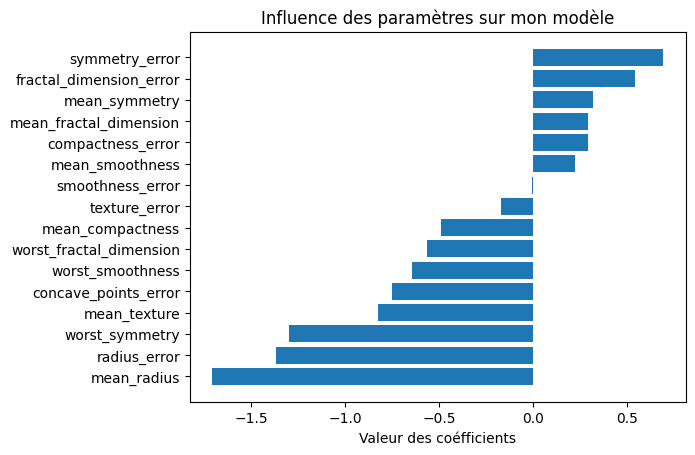

In [58]:
plt.title('Influence des paramètres sur mon modèle')
plt.xlabel('Valeur des coéfficients')
svm_f_importances(linear_model.coef_[0], features_name_corr)


In [59]:
linear_model.classes_
# 0 is Maligne
# 1 is benin

# Benin est donc la référence 

array([0, 1], dtype=int32)

<center><h4> Alors, êtes-vous devenu un bon médcin et savez vous détecter un cancer??</h4></center>